# **Paços para utilização:**


1.   Instalar todas as bibliotecas que foram utilizadas;
2.   Colocar o diretorio correto do banco de dados;
3.   Rodas todas as células do colab e aguardar;
4.   Após o treinamento será possível fazer a previsão utilizando predict_sentiment('*frase que deseja prever o sentimento*').


# **Obrservações Importantes**:



1. Na entrega final não será necessário o treinamento da IA





In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
import random
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
!pip install tensorflow-text
import tensorflow as tf
import tensorflow_text

# Pré-Processamento

# **Carregar Dados**

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cols = ['sentiment' , 'text']

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/BERT/dataset_sentimentos_expandido (1).csv',
                   header = None,
                   names = cols,
                   engine='python',
                   encoding='utf-8')

In [ ]:
data.shape

(63558, 2)

In [ ]:
data = data.drop(0)

In [ ]:
data = data.reset_index(drop=True)

In [ ]:
data.head()

,sentiment,text
0,1,Não estou conseguindo resolver meu problema e ...
1,3,Preciso de uma resposta imediata.
2,5,Atualização realizada conforme cronograma.
3,5,Encaminhei as informações por e-mail.
4,5,Recebi o protocolo de atendimento.


In [ ]:
data.head()

,sentiment,text
0,1,Não estou conseguindo resolver meu problema e ...
1,3,Preciso de uma resposta imediata.
2,5,Atualização realizada conforme cronograma.
3,5,Encaminhei as informações por e-mail.
4,5,Recebi o protocolo de atendimento.


In [ ]:
data.tail()

,sentiment,text
63552,0,Fiquei extremamente satisfeito com a agilidade...
63553,3,Dada a natureza crítica da situação e o impact...
63554,3,Dada a natureza crítica da situação e o impact...
63555,1,Apesar de inúmeras tentativas de contato e da ...
63556,0,Fiquei extremamente satisfeito com a agilidade...


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63557 entries, 0 to 63556
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  63557 non-null  object
 1   text       63557 non-null  object
dtypes: object(2)
memory usage: 993.2+ KB


# **Limpeza de Texto**

In [ ]:
!pip install ftfy emoji
from ftfy import fix_text
import emoji



In [ ]:
import unicodedata

def clean_tweet(tweet):
    # Corrige caracteres quebrados e entidades HTML
    tweet = fix_text(tweet)

    # Remove menções e URLs
    tweet = re.sub(r"@\w+", " ", tweet)
    tweet = re.sub(r"http\S+|www\S+", " ", tweet)

    # Converte emojis em texto (ex: 😊 -> :smiling_face:)
    tweet = emoji.demojize(tweet)

    # Transforma para minúsculas
    tweet = tweet.lower()

    # Remove acentos
    tweet = unicodedata.normalize('NFKD', tweet).encode('ASCII', 'ignore').decode('utf-8', 'ignore')

    # Remove caracteres não alfabéticos exceto pontuação relevante
    tweet = re.sub(r"[^a-zA-Z\s!?']", " ", tweet)

    # Normaliza repetições de letras (amoooo → amo)
    tweet = re.sub(r'(.)\1{2,}', r'\1\1', tweet)

    # Remove múltiplos espaços
    tweet = re.sub(r'\s+', ' ', tweet).strip()

    return tweet


In [ ]:
test = '99 ' + data.text[0]
test

'99 Não estou conseguindo resolver meu problema e estou cansado.'

In [ ]:
result = clean_tweet(test)
result

'nao estou conseguindo resolver meu problema e estou cansado'

In [ ]:
data_clean = [clean_tweet(tweet) for tweet in data.text]

In [ ]:
data_clean[0:4]

['nao estou conseguindo resolver meu problema e estou cansado',
 'preciso de uma resposta imediata',
 'atualizacao realizada conforme cronograma',
 'encaminhei as informacoes por e mail']

In [ ]:
data_labels = data.sentiment.values
data_labels

array(['1', '3', '5', ..., '3', '1', '0'], dtype=object)

In [ ]:
data_labels

array(['1', '3', '5', ..., '3', '1', '0'], dtype=object)

# **Tokenização**

In [ ]:
!pip install tensorflow tensorflow_hub tensorflow_text
from transformers import AutoTokenizer
from transformers import AutoModelForPreTraining
from transformers import AutoModel

In [ ]:
import tensorflow as tf
import numpy as np
from transformers import AutoTokenizer, TFBertModel
import unicodedata
import re
import emoji
import os
import keras
from keras.saving import register_keras_serializable

In [ ]:
print("Carregando tokenizer e modelo BERTimbal...")
MODEL_NAME = 'neuralmind/bert-base-portuguese-cased'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)

MAX_LENGTH = 64
BATCH_SIZE = 16
NB_CLASSES = 6

Carregando tokenizer e modelo BERTimbal...


In [ ]:
def encode_sentence_bert(sentence):
    encoded = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='tf'
    )
    return encoded['input_ids'][0], encoded['attention_mask'][0]

print("Codificando sentenças...")
bert_inputs_encoded = [encode_sentence_bert(sentence) for sentence in data_clean]

all_input_ids = tf.stack([pair[0] for pair in bert_inputs_encoded])
all_attention_masks = tf.stack([pair[1] for pair in bert_inputs_encoded])
all_labels = tf.convert_to_tensor(data_labels, dtype=tf.int32)

print(f"Total de exemplos: {len(data_labels)}")
print(f"Shape dos Input IDs: {all_input_ids.shape}")
print(f"Shape das Attention Masks: {all_attention_masks.shape}")
print(f"Shape dos Labels: {all_labels.shape}")


bert_dataset = tf.data.Dataset.from_tensor_slices(
    ((all_input_ids, all_attention_masks), all_labels)
)


BUFFER_SIZE = len(data_labels)
bert_dataset = bert_dataset.shuffle(BUFFER_SIZE)


bert_dataset = bert_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

NB_BATCHES = len(data_labels) // BATCH_SIZE
if len(data_labels) % BATCH_SIZE != 0:
    NB_BATCHES += 1
NB_BATCHES_TEST = NB_BATCHES // 10
if NB_BATCHES_TEST == 0 and NB_BATCHES > 0:
     NB_BATCHES_TEST = 1

print(f"Total de batches: {NB_BATCHES}")
print(f"Batches de teste: {NB_BATCHES_TEST}")
print(f"Batches de treino: {NB_BATCHES - NB_BATCHES_TEST}")

test_dataset = bert_dataset.take(NB_BATCHES_TEST)
train_dataset = bert_dataset.skip(NB_BATCHES_TEST)

Codificando sentenças...
Total de exemplos: 63557
Shape dos Input IDs: (63557, 64)
Shape das Attention Masks: (63557, 64)
Shape dos Labels: (63557,)
Total de batches: 3973
Batches de teste: 397
Batches de treino: 3576


In [ ]:
class BERTimbauClassifier(tf.keras.Model):
    def __init__(self, nb_classes=NB_CLASSES, dropout_rate=0.3, model_name=MODEL_NAME):
        super(BERTimbauClassifier, self).__init__(name="BERTimbauClassifier")
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        if nb_classes == 2:
            self.classifier = tf.keras.layers.Dense(1, activation='sigmoid', name='classifier')
        else:
            self.classifier = tf.keras.layers.Dense(nb_classes, activation='softmax', name='classifier')


    def call(self, inputs, training=False):
        input_ids, attention_mask = inputs
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, training=training)
        pooled_output = bert_output.pooler_output
        x = self.dropout(pooled_output, training=training)
        return self.classifier(x)

print("Instanciando e compilando o modelo...")
model = BERTimbauClassifier(nb_classes=NB_CLASSES, dropout_rate=0.3)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

if NB_CLASSES == 2:
    loss_function = 'binary_crossentropy'
    metrics_list = ['accuracy']
else:
    loss_function = 'sparse_categorical_crossentropy'
    metrics_list = ['sparse_categorical_accuracy']

model.compile(optimizer=optimizer,
              loss=loss_function,
              metrics=metrics_list)

try:
    sample_batch_inputs, _ = next(iter(train_dataset))
    model(sample_batch_inputs)
    model.summary()
except StopIteration:
    print("Não foi possível gerar um batch de exemplo para model.summary() (dataset de treino vazio?).")


checkpoint_dir = '/content/drive/MyDrive/BERT' #coloque o caminho que será salvo o checkpoint
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'ckpt')

ckpt = tf.train.Checkpoint(model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep=1)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint).expect_partial()
    print(f'Último checkpoint restaurado de {ckpt_manager.latest_checkpoint}')
else:
    print("Nenhum checkpoint encontrado, iniciando treinamento do zero.")


class MyCustomCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        save_path = ckpt_manager.save()
        print("\nCheckpoint salvo para a época {} em {}".format(epoch + 1, save_path))


EPOCHS = 5

print(f"\nIniciando treinamento por {EPOCHS} épocas...")

history = model.fit(train_dataset,
                    epochs=EPOCHS,
                    callbacks=[MyCustomCallBack()],
                    validation_data=test_dataset)
print("\nTreinamento concluído!")

if NB_BATCHES_TEST > 0:
    print("\nAvaliando o modelo no conjunto de teste...")
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    print(f"Loss no Teste: {loss:.4f}")
    if NB_CLASSES == 2:
         print(f"Acurácia no Teste: {accuracy:.4f}")
    else:
         print(f"Acurácia Categórica Esparsa no Teste: {accuracy:.4f}")

else:
    print("\nNenhum dado de teste para avaliação final.")


Instanciando e compilando o modelo...


tf_model.h5:   0%|          | 0.00/529M [00:00<?, ?B/s]

Some layers from the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "BERTimbauClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (16, 6)                │         4,614 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,614 (18.02 KB)

 Trainable params: 4,614 (18.02 KB)

 Non-trainable params: 0 (0.00 B)

Nenhum checkpoint encontrado, iniciando treinamento do zero.

Iniciando treinamento por 5 épocas...
Epoch 1/5
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.6688 - sparse_categorical_accuracy: 0.3676
Checkpoint salvo para a época 1 em /content/drive/MyDrive/BERT/ckpt-1
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 92s 19ms/step - loss: 1.6687 - sparse_categorical_accuracy: 0.3676 - val_loss: 1.2489 - val_sparse_categorical_accuracy: 0.8753
Epoch 2/5
3575/3576 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1982 - sparse_categorical_accuracy: 0.7954
Checkpoint salvo para a época 2 em /content/drive/MyDrive/BERT/ckpt-2
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - loss: 1.1981 - sparse_categorical_accuracy: 0.7954 - val_loss: 0.9041 - val_sparse_categorical_accuracy: 0.8934
Epoch 3/5
3573/3576 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.9047 - sparse_categorical_accuracy: 0.8579
Checkpoint salvo para a época 3 em /content/drive/MyDrive/BERT/ckpt-3
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 47s 13ms/step - loss

In [ ]:
user_specific_label_map = {
    0: 'Satisfação',
    1: 'Frustração',
    2: 'Confusão',
    3: 'Urgência/Pressão',
    4: 'Raiva/Irritação',
    5: 'Neutro'
}

def predict_sentiment(sentence):

    try:
        cleaned_sentence = clean_tweet(sentence)
    except NameError:
        print("Aviso: Função clean_tweet não encontrada. Usando frase original.")
        cleaned_sentence = sentence

    encoded = tokenizer.encode_plus(
        cleaned_sentence,
        add_special_tokens=True,
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors='tf'
    )

    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']


    output_probabilities = model((input_ids, attention_mask), training=False)[0]


    predicted_class_index = tf.argmax(output_probabilities).numpy()

    predicted_sentiment_label = user_specific_label_map.get(predicted_class_index, f"Classe Desconhecida ({predicted_class_index})")

    print(f"Sentimento previsto: {predicted_sentiment_label}")

print("\n--- Testando a Previsão de Sentimento ---")



--- Testando a Previsão de Sentimento ---


In [ ]:
predict_sentiment("Estou aguardando há muito tempo e ninguém responde.")

Sentimento previsto: Frustração


In [ ]:
predict_sentiment('Já tentei várias vezes e nunca consigo acessar minha conta.')

Sentimento previsto: Frustração


In [ ]:
predict_sentiment('Estou muito contente com o resultado final, superou minhas expectativas!')

Sentimento previsto: Satisfação


In [ ]:
predict_sentiment('Esse serviço é uma piada, estou indignado')

Sentimento previsto: Raiva/Irritação


In [ ]:
predict_sentiment("Eu não sei oq isso significa")

Sentimento previsto: Confusão


In [ ]:
predict_sentiment('Meu cartão venceu, como solicito um novo?')

Sentimento previsto: Neutro


In [ ]:
predict_sentiment("Não entendi o procedimento descrito, ficou muito confuso.")

Sentimento previsto: Confusão


In [ ]:
predict_sentiment("O procedimento foi realizado conforme o cronograma previamente estabelecido, sem intercorrências significativas ou alterações dignas de nota.")

Sentimento previsto: Neutro


In [ ]:
predict_sentiment('O evento ocorrerá conforme planejado.')

Sentimento previsto: Neutro


In [ ]:
predict_sentiment('Precisamos agir agora, é uma questão de minutos!')

Sentimento previsto: Urgência/Pressão


In [ ]:
predict_sentiment('Você poderia me ajudar nesse caso?')

Sentimento previsto: Confusão


In [ ]:
predict_sentiment('Já perdi a paciência, é um descaso total.')

Sentimento previsto: Raiva/Irritação


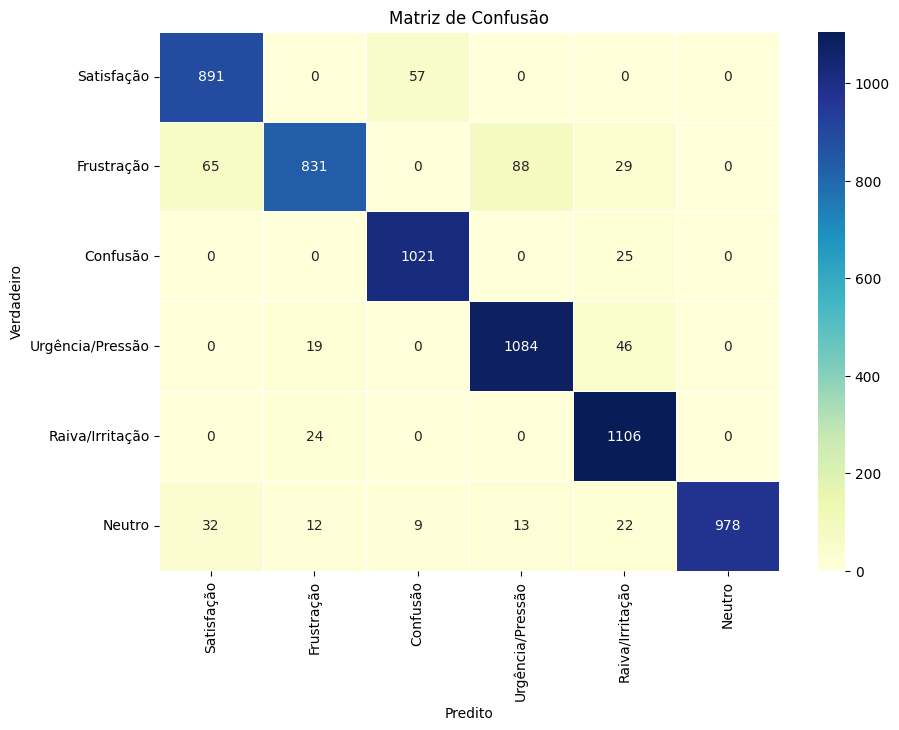

                  precision    recall  f1-score   support

      Satisfação       0.90      0.94      0.92       948
      Frustração       0.94      0.82      0.88      1013
        Confusão       0.94      0.98      0.96      1046
Urgência/Pressão       0.91      0.94      0.93      1149
 Raiva/Irritação       0.90      0.98      0.94      1130
          Neutro       1.00      0.92      0.96      1066

        accuracy                           0.93      6352
       macro avg       0.93      0.93      0.93      6352
    weighted avg       0.93      0.93      0.93      6352



In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = []
predicted_labels = []

for batch in test_dataset:
    (input_ids, attention_mask), labels = batch
    logits = model((input_ids, attention_mask), training=False)
    predictions = tf.argmax(logits, axis=1)

    true_labels.extend(labels.numpy())
    predicted_labels.extend(predictions.numpy())

class_indices = [0, 1, 2, 3, 4, 5]

class_names = ['Satisfação', 'Frustração', 'Confusão', 'Urgência/Pressão', 'Raiva/Irritação', 'Neutro']

cm = confusion_matrix(true_labels, predicted_labels, labels=class_indices)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names, linewidths=0.5)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=class_names, labels=class_indices))


Avaliação

In [ ]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

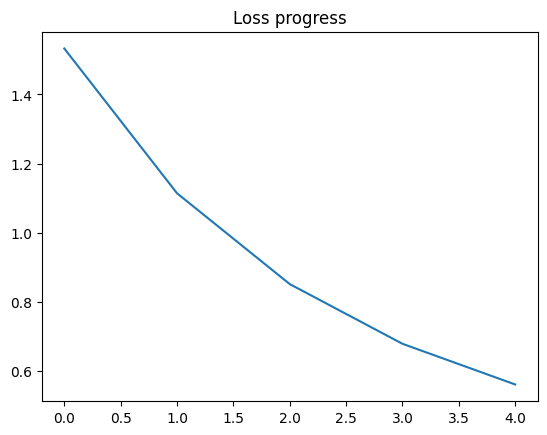

In [ ]:
plt.plot(history.history['loss'])
plt.title('Loss progress');

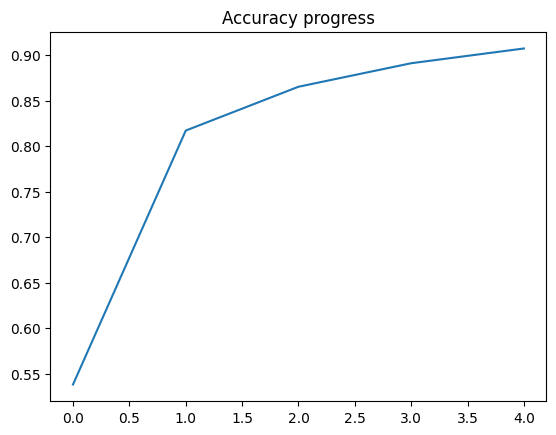

In [ ]:
plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Accuracy progress');

In [ ]:
results = model.evaluate(test_dataset)
print(results)

397/397 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.4300 - sparse_categorical_accuracy: 0.9261
[0.429192453622818, 0.928683876991272]
